In [20]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# Seed para que las redes con iguales parametros no generen resultados aleatorios y tener repetibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Para las graficas importamos matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#Función para plotear
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

#Función Rounded Accuracy
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

    
#Traemos los datos de Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full_normalized = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full_normalized[:-5000], X_train_full_normalized[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

#Función para ver los resultados de las reconstrucciones
def show_reconstructions(model, images=X_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [69]:
#Creamos una clase para integrar la MMD como un loss custom
class MMD:
    #la funcion init para inicializar el factor de escalada
    def __init__(self, scale=1.0):
        self.scale = scale
        
    #En la funcion call se calcula la perdida escalada y la retorna
    def __call__(self, y_true, y_pred):
        print((y_pred.shape))
        # Calcula la MMD
        MMD = self.compute_mmd(y_true,y_pred)
        # Retorna la MMD
        return self.scale*MMD
    
    #definimos la operacion MMD
    def compute_mmd(z_prior,z):
        #definimos la operacion kernel como un kernel gaussiano
        def kernel_fn(X, Y, sigma=1.0):
            squared_distance = tf.reduce_sum(tf.square(X - Y), axis=1)
            return tf.exp(-squared_distance / (2 * sigma ** 2))
        # Calcula los kernels
        K_zz = kernel_fn(z, z)
        K_zz_prior = kernel_fn(z, z_prior)
        K_prior_prior = kernel_fn(z_prior, z_prior)

        # Calcula MMD
        mmd = tf.reduce_mean(K_zz) + tf.reduce_mean(K_prior_prior) - 2 * tf.reduce_mean(K_zz_prior)
        return mmd

In [55]:
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 8
#Creamos una capa lambda que realice la reparametrización
from tensorflow.keras.layers import Lambda

def sampling(args):

    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
    return z
# Capa lambda para el muestreo
sampling_layer = Lambda(sampling, output_shape=(latent_dim,))

In [23]:
#Definimos el encoder
encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))
x = keras.layers.RandomFlip(mode="horizontal")(encoder_inputs)#Usamos unas capas de random flip y random contrast para aumentar artificialmente los datos de entrada
x = keras.layers.RandomContrast(factor=0.2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)
z = sampling_layer([z_mean,z_log_var])
#encoder = tf.keras.Model(encoder_inputs, z, name='encoder')

#Definimos el decoder con la API funcional
#decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
decoder_inputs = tf.keras.layers.Dense(7*7*64, activation='relu')(z)
x = tf.keras.layers.Reshape((7, 7, 64))(decoder_inputs)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x = keras.layers.BatchNormalization()(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
#decoder = tf.keras.Model(decoder_inputs, decoder_outputs, name='decoder')
vae = tf.keras.Model(encoder_inputs,[z,decoder_outputs],name="VAE")


#Para poder usar el parametro de escalado y darle pesos a los diferentes loss creamos una clase para un loss custom escalado
class ScaledBinaryCrossentropy:
    #la funcion init para inicializar el factor de escalada
    def __init__(self, scale=1.0):
        self.scale = scale
        
    #En la funcion call se calcula la perdida escalada y la retorna
    def __call__(self, y_true, y_pred):
        # Calcula la binary crossentropy
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        # Retorna la binary crossentropy escalada
        return self.scale * bce

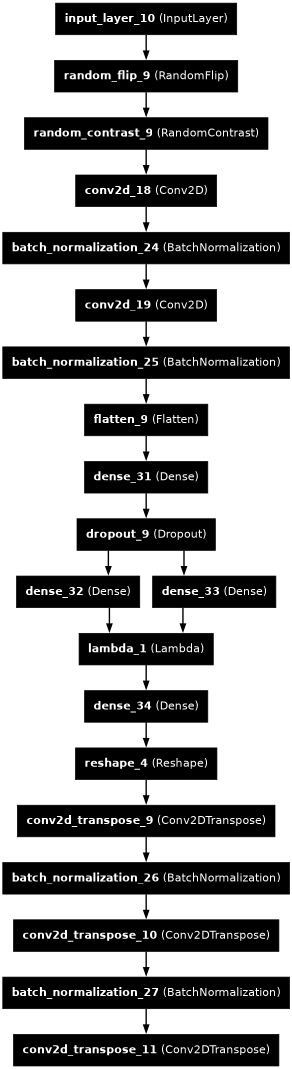

In [24]:
tf.keras.utils.plot_model(vae,show_layer_names=True,dpi=50)

In [73]:
#Luego de definir las funciones y la clase VAE, se crea y compila  el modelo

#Definimos los pesos que llevaran los loss
alpha = 0.6
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 0.1 

z_prior = tf.random.normal(shape=(0,8))
#Creamos el objeto loss que va a calcular la crossentropia escalada
loss1= MMD(alpha)
loss2= ScaledBinaryCrossentropy(beta)
#Compilamos
vae.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=[loss1,loss2],metrics=[rounded_accuracy])

In [74]:
#Clear session para no guardar datos de entrenamientos anteriores
history=vae.fit(X_train, [z_prior,X_train], epochs=2, batch_size=32, validation_data=(X_valid, X_valid))

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 55000
'y' sizes: 0, 55000


In [ ]:
#Crear un custom loss para que la red tenga 2 salidas, y una sea el loss de regularización del espacio latente

In [ ]:
#Graficamos el loss de entrenamiento y validación
plt.plot(history.history["loss"],label="Loss")
plt.plot(history.history["val_loss"],label="Val_loss")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.49,0.52)
plt.legend()
plt.show()

In [ ]:
#Graficamos el accuracy de entrenamiento y el de validación

plt.plot(history.history["rounded_accuracy"],label="Accuracy")
plt.plot(history.history["val_rounded_accuracy"],label="Val_Accuracy")
plt.grid(True)
#plt.xlim(0,20)
#plt.ylim(0.7,0.75)
plt.legend()
plt.show()

In [ ]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae)
plt.show()

In [ ]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

In [ ]:
#Para revisar el espacio latente usamos PCA y TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extraer los valores latentes
z_mean, _ = vae.encoder.predict(X_test)

# Aplicar PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_mean)

# Aplicar TSNE
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z_mean)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# PCA
plt.subplot(1, 2, 1)
plt.scatter(z_pca[:, 0], z_pca[:, 1], c='blue', s=2)
plt.title('PCA del espacio latente')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

# TSNE
plt.subplot(1, 2, 2)
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c='red', s=2)
plt.title('TSNE del espacio latente')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')

plt.show()

**Por comparación vamos a revisar que pasa cuando no se añade el MMD, y cuando el ancho de banda es muy pequeño y muy grande**

In [ ]:
#Luego de definir las funcions y la clase VAE, se crea y compila  el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 8
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Definimos los pesos que llevaran los loss
alpha = 0
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 0.1 
#Usamos la clase VAE para definir el modelo
vae_0 = VAE(encoder, decoder,alpha,sigma)


#Creamos el objeto loss que va a calcular la crossentropia escalada
loss2=ScaledBinaryCrossentropy(beta)
#Compilamos
vae_0.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [ ]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae_0.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))

In [ ]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae_0)
plt.show()

In [ ]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae_0.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

**Verificamos que pasa si el sigma es muy pequeño**

In [ ]:
#Luego de definir las funcions y la clase VAE, se crea y compila  el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 8
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Definimos los pesos que llevaran los loss
alpha = 0.6
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 0.0001 
#Usamos la clase VAE para definir el modelo
vae_min = VAE(encoder, decoder,alpha,sigma)

#Creamos el objeto loss que va a calcular la crossentropia escalada
loss2=ScaledBinaryCrossentropy(beta)
#Compilamos
vae_min.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [ ]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae_min.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))

In [ ]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae_min)
plt.show()

In [ ]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae_min.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

**Ahora con un sigma muy grande**

In [ ]:
#Luego de definir las funcions y la clase VAE, se crea y compila  el modelo
#Este parametro determina el tamaño del espacio latente, o lo que es lo mismo, el número de neuronas de las últimas capas del encoder
latent_dim = 8
#Llamamos las funciones para crear el encoder y decoder
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
#Definimos los pesos que llevaran los loss
alpha = 0.6
beta= 1-alpha
#Definimos el ancho de banda del kernel
sigma = 10000
#Usamos la clase VAE para definir el modelo
vae_max = VAE(encoder, decoder,alpha,sigma)

#Creamos el objeto loss que va a calcular la crossentropia escalada
loss2=ScaledBinaryCrossentropy(beta)
#Compilamos
vae_max.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-1), loss=loss2,metrics=[rounded_accuracy])

In [ ]:
#Clear session para no guardar datos de entrenamientos anteriores
keras.backend.clear_session()
history=vae_max.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_valid, X_valid))

In [ ]:
#Visualizamos las reconstrucciones usando la funcion ya definida
show_reconstructions(vae_max)
plt.show()

In [ ]:
#Hacemos un mapa de calor para visualizar la distribucion de las medias definidas para cada dato en el encoder
mean, *_ = vae_max.encoder.predict(X_train)
fig = plt.figure(figsize=(11, 7))
plt.scatter(mean[:, 0], mean[:, 1], c=y_train, cmap="magma")
plt.colorbar()
plt.show()

# Discusion

**Se puede ver que la MMD cumple bien el papel de regularizar el espacio latente como lo hacia la divergencia KL, el loss empeoró en general al eliminar esta regularizacion de la red.**

**El parametro sigma no tiene tanto impacto en la reconstrucción pero si en la regularización, el espacio latente aparenta ser mucho más disperso al poner valores muy extremos de sigma, tanto pequeños como grandes.**